# 다중선형회귀 (1) - 농어의 무게 예측 모형 만들기

독립변수가 두 개 이상인 경우의 선형회귀분석

분석 정확도를 높이기 위해 적절하지 않은 변수를 추려내는 과정을 반복적으로 수행하여 최적의 독립변수 그룹을 찾아내는 것을 목표로 한다.

## #01. 준비작업

### [1] 패키지 참조

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import numpy as np
import seaborn as sb
from tabulate import tabulate
from matplotlib import pyplot as plt
from pandas import read_excel, DataFrame

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from scipy.stats import t
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson

from statsmodels.formula.api import ols

### [2] 그래프 초기화

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["axes.unicode_minus"] = False

### [3] 데이터 가져오기

In [3]:
origin = read_excel("https://data.hossam.kr/mldata/fish.xlsx")
print(origin.info())
origin.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## #02. 데이터 확인

### [1]  산점도 행렬

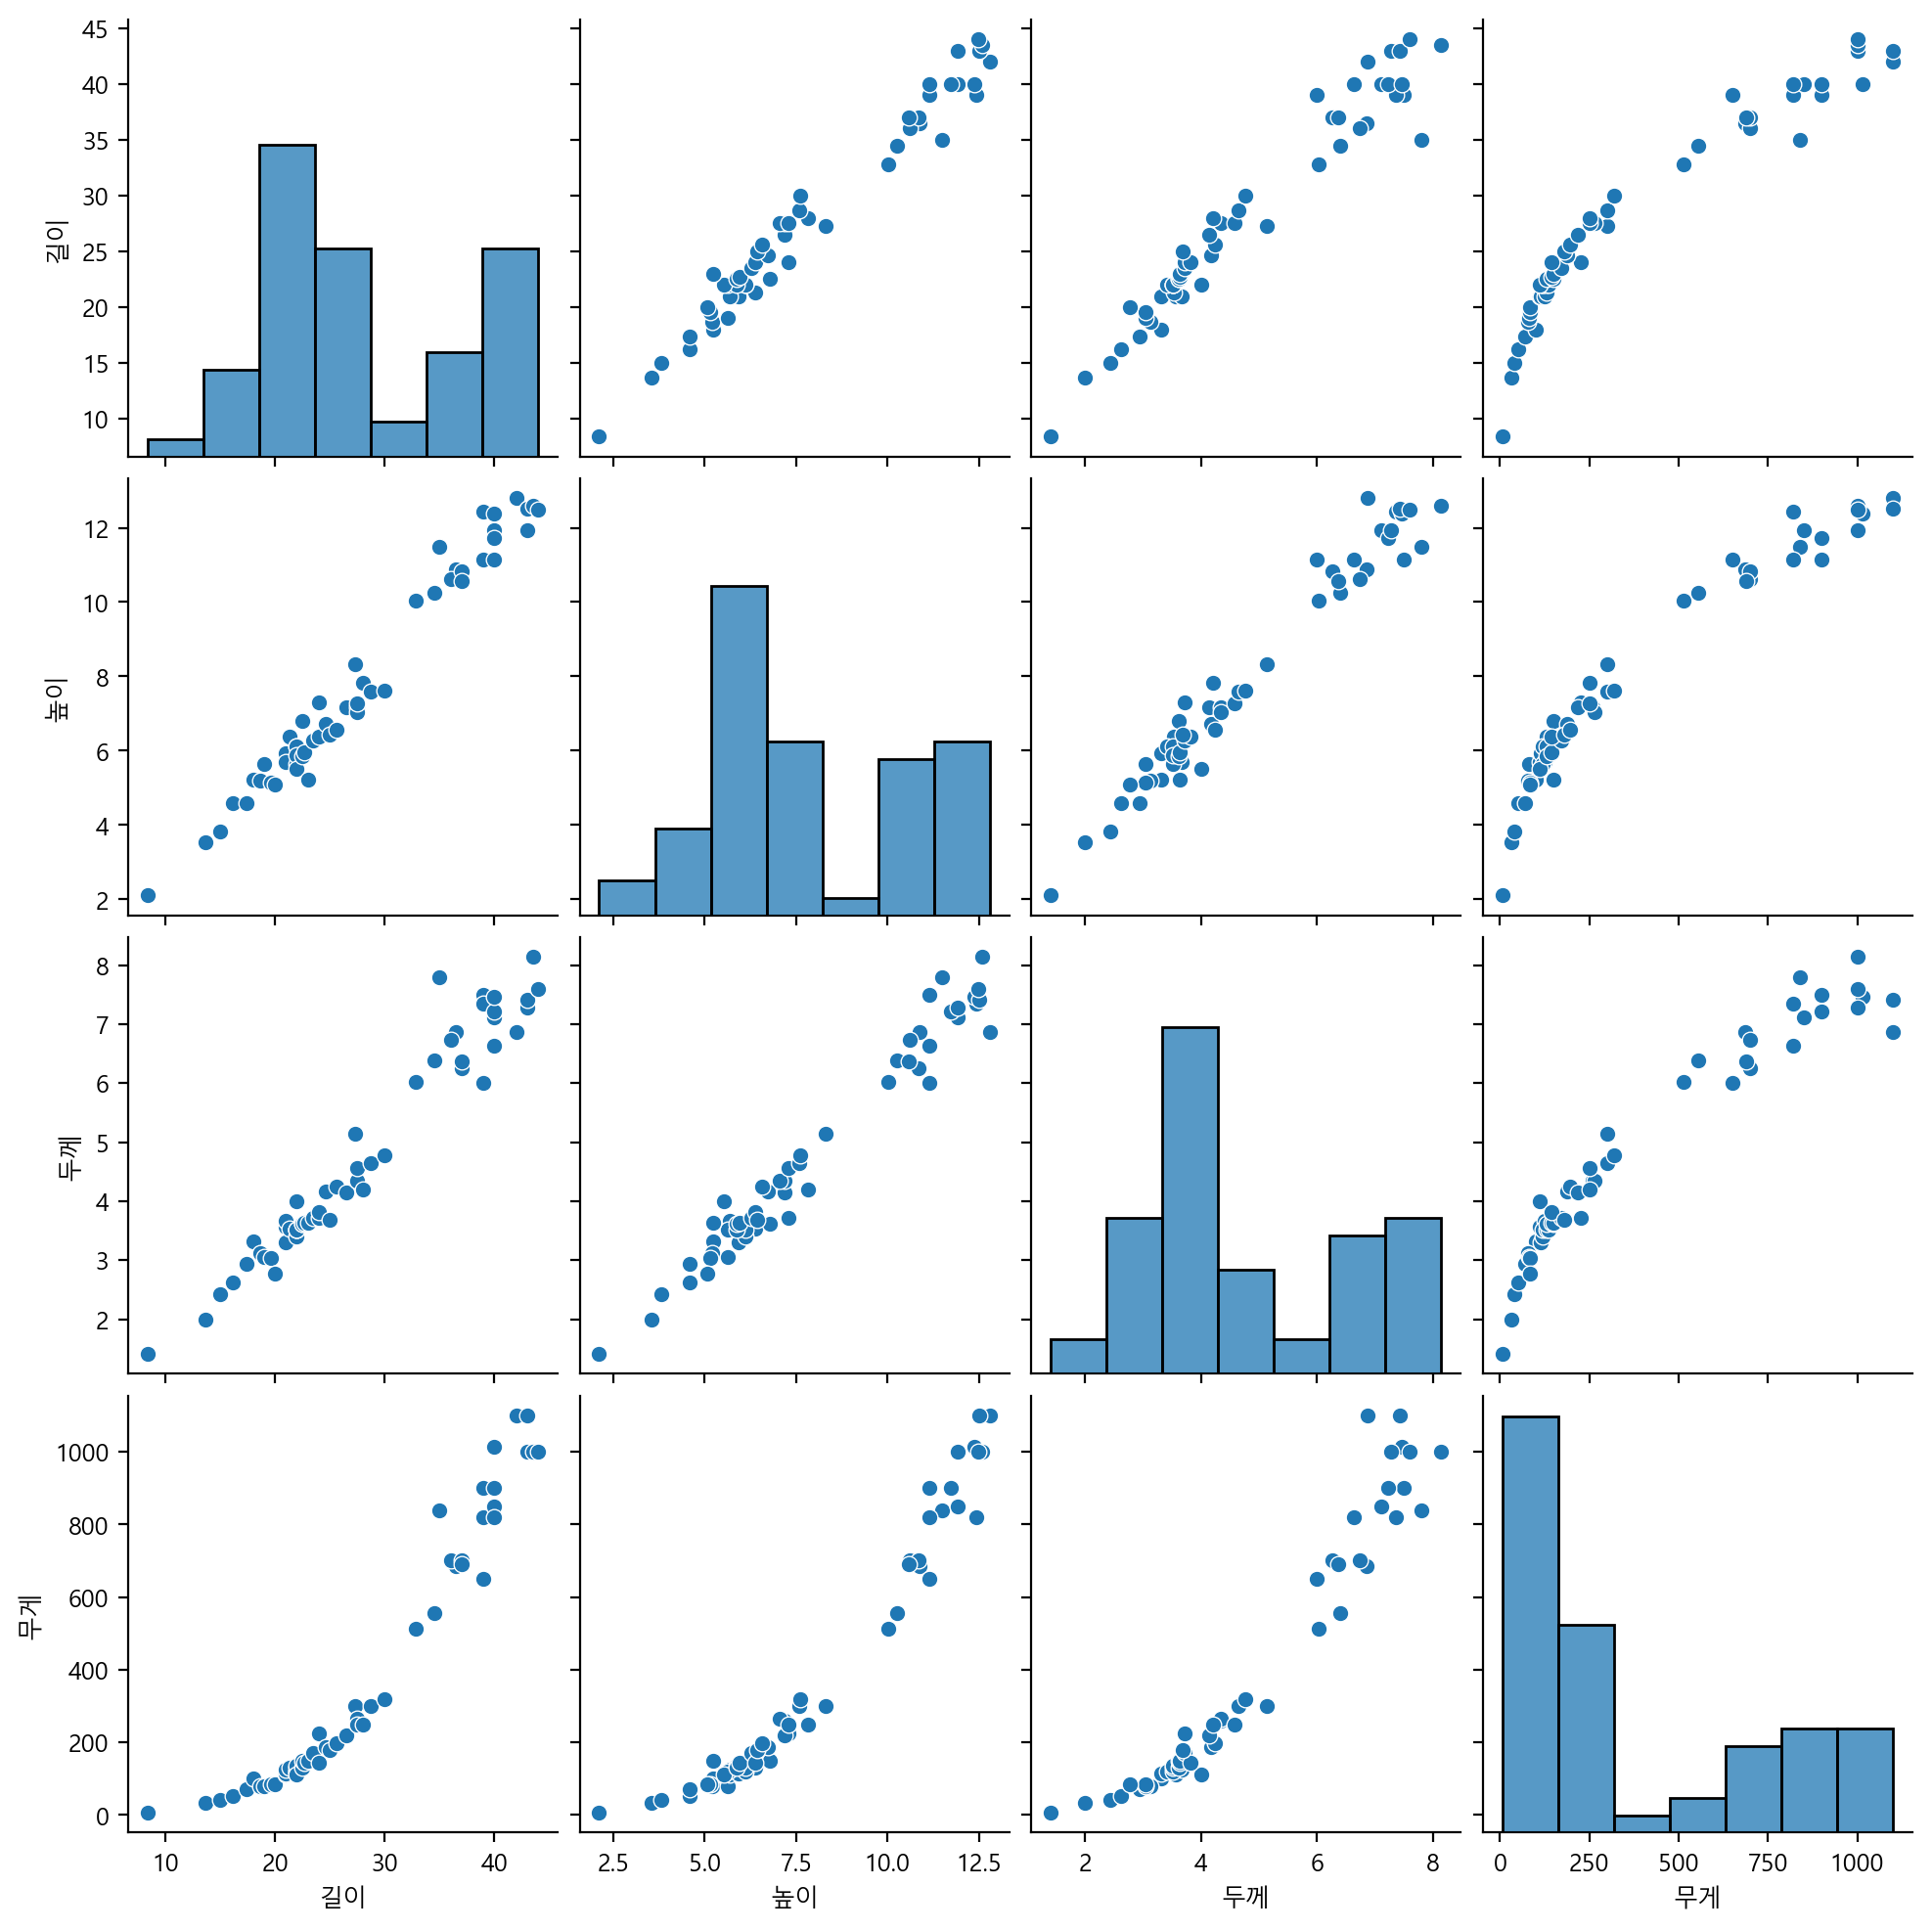

In [4]:
sb.pairplot(origin)
plt.show()
plt.close()

> 종속변수인 무게에 길이, 높이, 두께가 모두 높은 상관성을 갖는 것으로 보인다. 무게에 대해 선형보다는 비선형으로 보이지만 여기서는 선형성을 만족한다고 가정하고 진행한다.
> 
> 독립변수간(길이-높이, 높이-두께, 두께-길이)에도 상관성이 있는 것으로 확인된다. 이와 같은 경우를 자기상관이 있다고 하는데, 이 경우 회귀분석을 수행하면 다중공선성 문제가 발생하여 모델의 신뢰성이 떨어진다.
> 
> 예제 데이터이므로 여기서는 다중공선성을 무시하고 진행하도록 한다.

### [2] 상관계수 히트맵

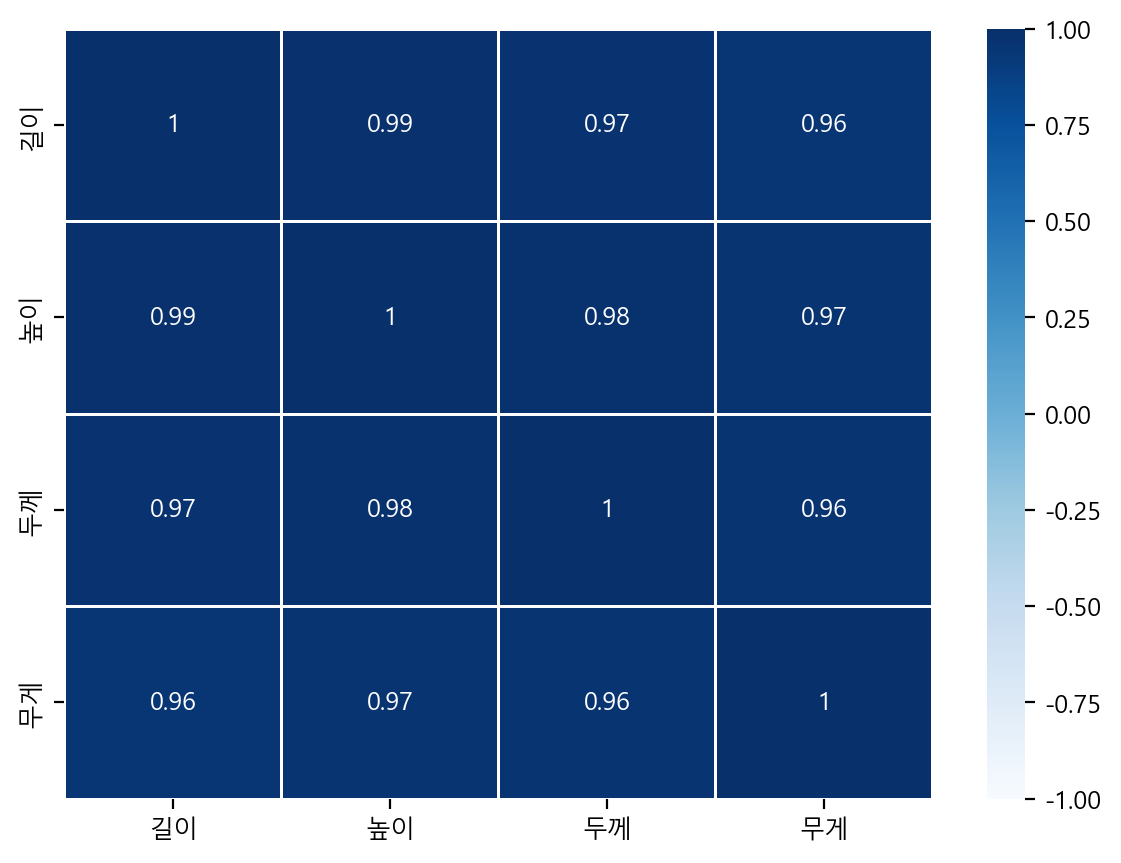

In [5]:
plt.figure(figsize=(7,5), dpi=200)
sb.heatmap(origin.corr(method='pearson'), annot = True, cmap = 'Blues',
           vmin = -1, vmax=1, linewidths=0.5)
plt.show()
plt.close()

> 요인들간의 자기상관성이 있는 것으로 보인다.

## #03.  데이터 전처리

데이터를 분리한다.

In [7]:
x = origin[['길이', '높이', '두께']]
y = origin['무게']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39,), (17,))

## #04. 선형회귀 분석

+-------------------------------+--------------+--------------+
|                               |   훈련데이터 |   검증데이터 |
|-------------------------------+--------------+--------------|
| 결정계수(R2)                  |     0.949944 |     0.919246 |
| 평균절대오차(MAE)             |    61.8824   |    58.2871   |
| 평균제곱오차(MSE)             |  6089.38     |  8828.88     |
| 평균오차(RMSE)                |    78.0345   |    93.9621   |
| 평균 절대 백분오차 비율(MAPE) |    46.2303   |   327.91     |
| 평균 비율 오차(MPE)           |   nan        |   304.702    |
+-------------------------------+--------------+--------------+



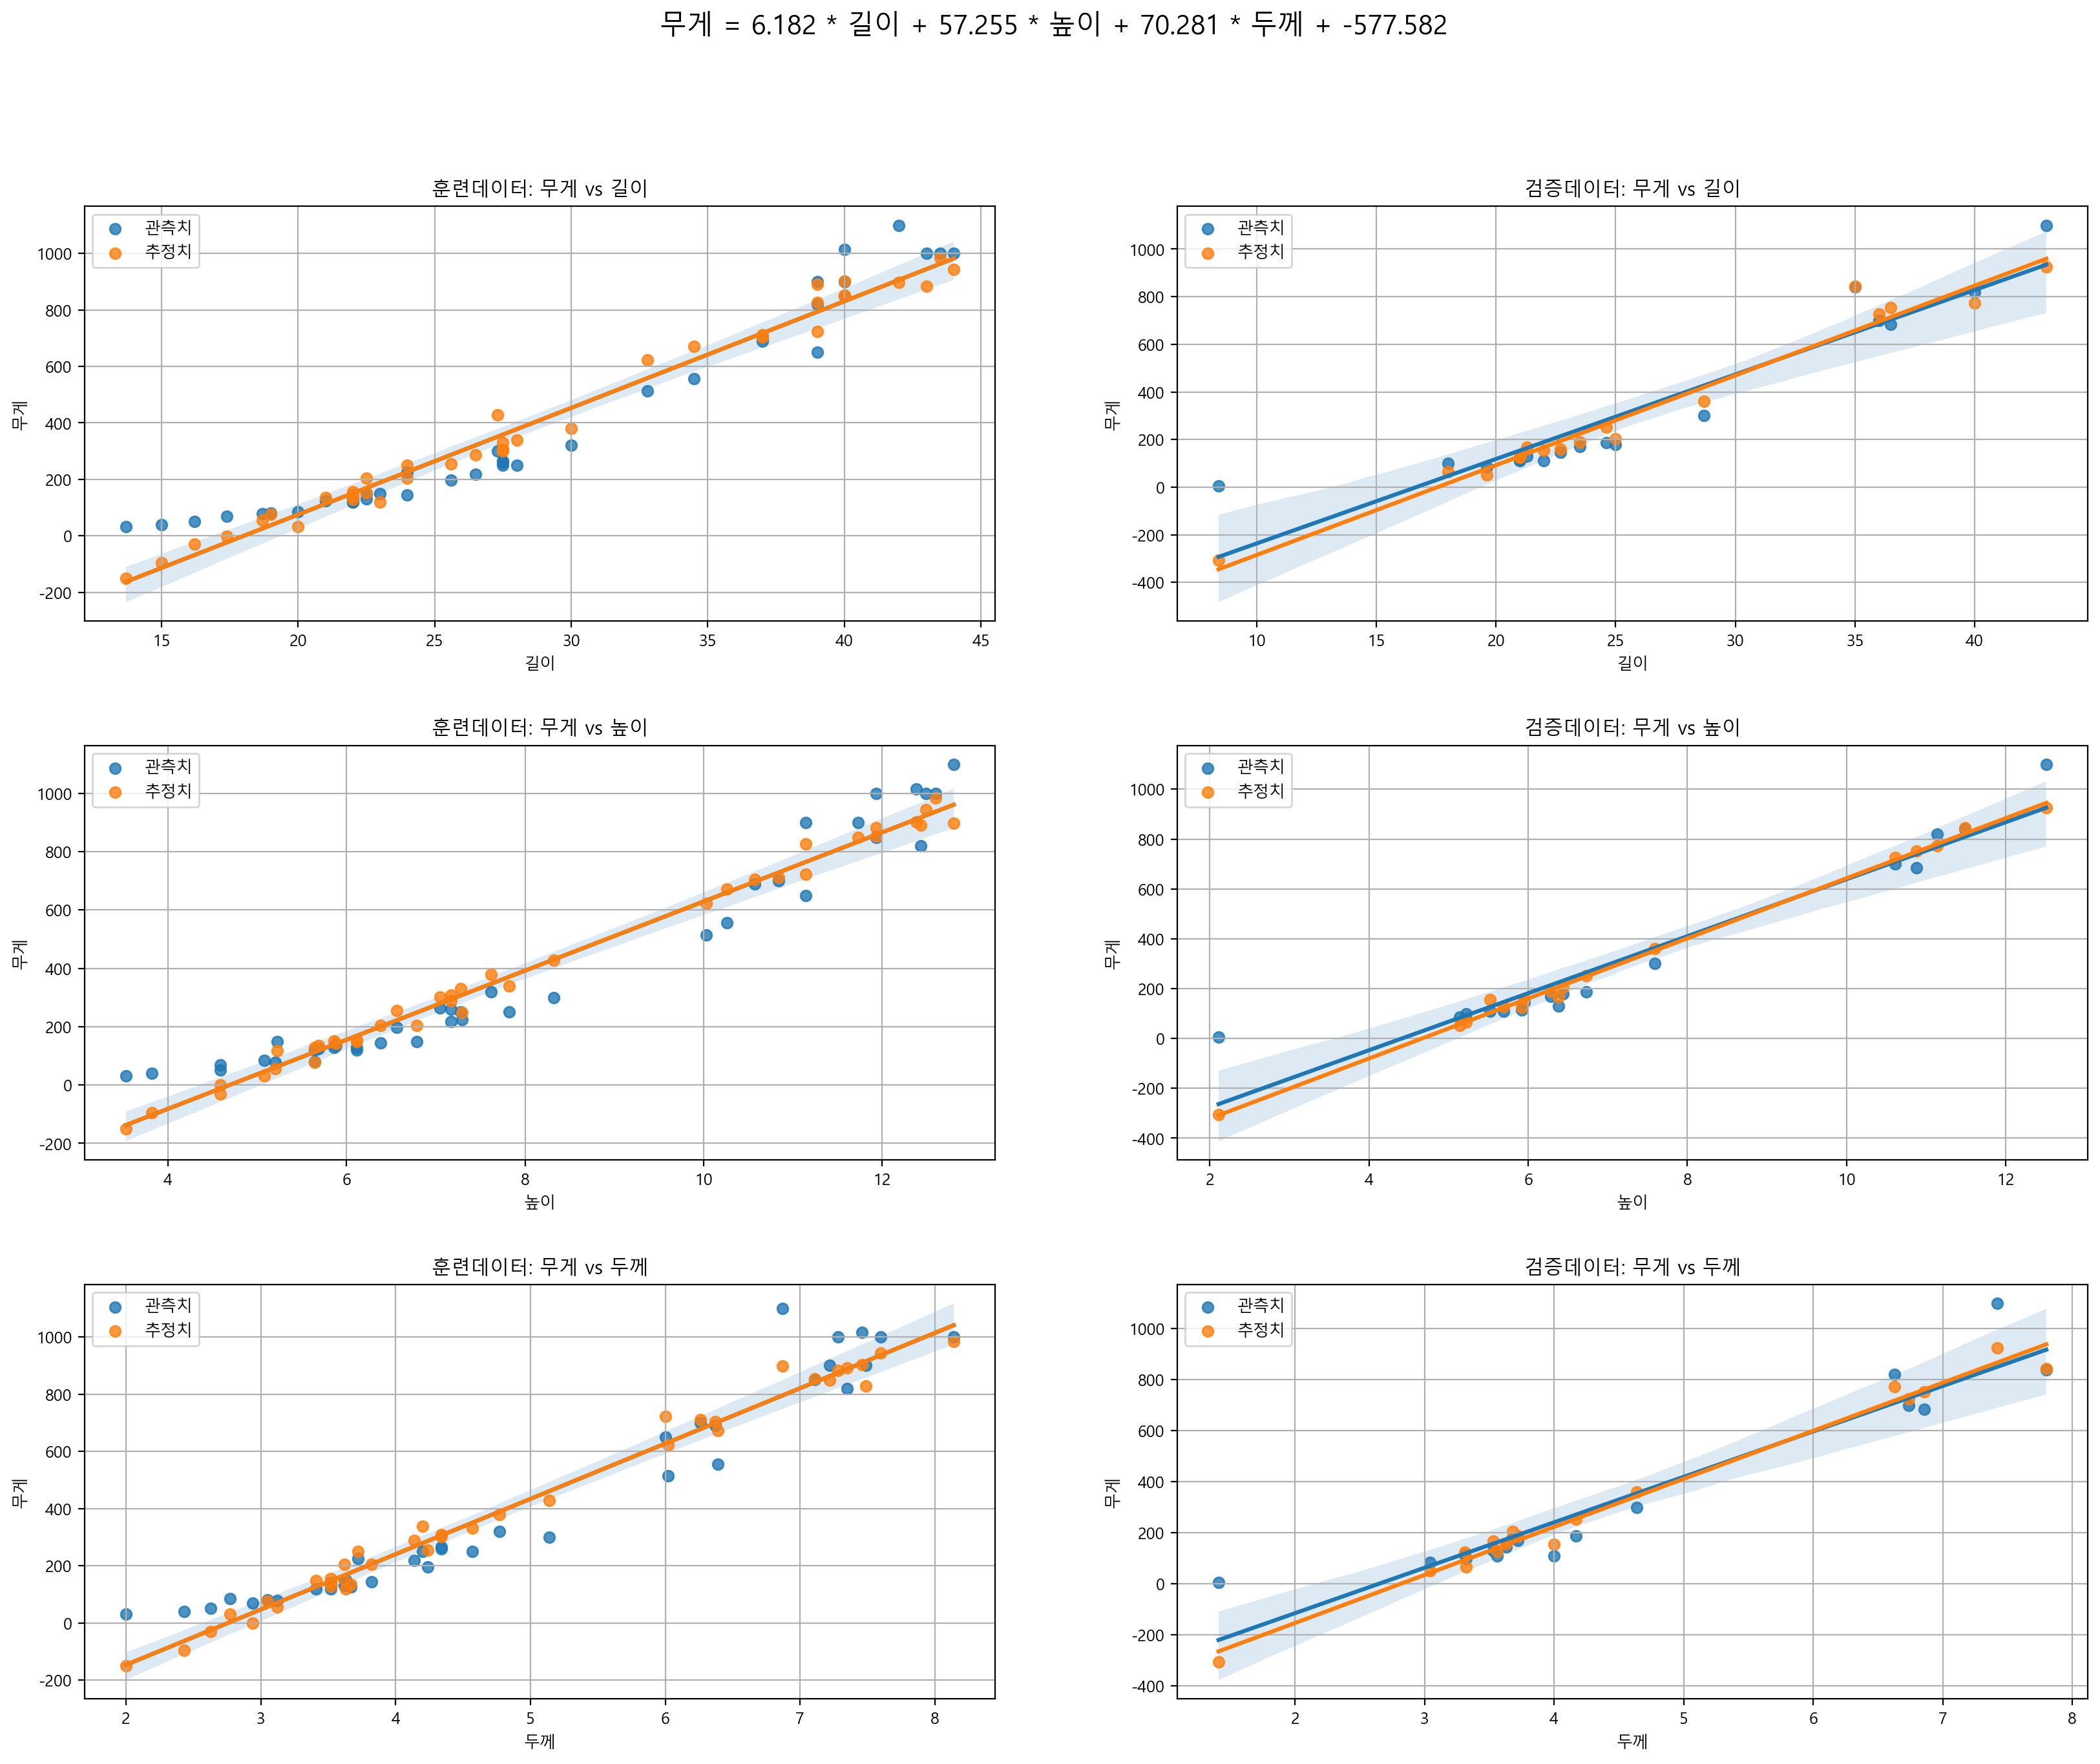

In [8]:
yname = "무게"
xnames = x_train.columns
size = len(xnames)

# 분석모델 생성
model = LinearRegression()
fit = model.fit(x_train, y_train)

# 회귀식
expr = "{yname} = ".format(yname=yname)

for i, v in enumerate(xnames):
    expr += "%0.3f * %s + " % (fit.coef_[i], v)

expr += "%0.3f" % fit.intercept_

# 추정치 생성
y_train_pred = fit.predict(x_train)
y_test_pred = fit.predict(x_test)

# 성능평가
result1 = {
    "결정계수(R2)": r2_score(y_train, y_train_pred),
    "평균절대오차(MAE)": mean_absolute_error(y_train, y_train_pred),
    "평균제곱오차(MSE)": mean_squared_error(y_train, y_train_pred),
    "평균오차(RMSE)": np.sqrt(mean_squared_error(y_train, y_train_pred)),
    "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((y_train - y_train_pred) / y_train) * 100),
    "평균 비율 오차(MPE)": np.mean((y_train - y_train_pred) / y_test * 100)
}

result2 = {
    "결정계수(R2)": r2_score(y_test, y_test_pred),
    "평균절대오차(MAE)": mean_absolute_error(y_test, y_test_pred),
    "평균제곱오차(MSE)": mean_squared_error(y_test, y_test_pred),
    "평균오차(RMSE)": np.sqrt(mean_squared_error(y_test, y_test_pred)),
    "평균 절대 백분오차 비율(MAPE)": np.mean(np.abs((y_test - y_test_pred) / y_test) * 100),
    "평균 비율 오차(MPE)": np.mean((y_test - y_test_pred) / y_test * 100)
}

result_df = DataFrame([result1, result2], index=["훈련데이터", "검증데이터"])
print(tabulate(result_df.T, headers='keys', tablefmt='psql', showindex=True), end="\n\n")


# 시각화
fig, ax = plt.subplots(len(xnames), 2, figsize=(20, 5*size), dpi=200)
fig.subplots_adjust(hspace=0.3)
fig.suptitle(expr, fontsize=15)

for i, v in enumerate(xnames):
    sb.regplot(x=x_train[v], y=y_train, ci=95, ax=ax[i][0], label='관측치')
    sb.regplot(x=x_train[v], y=y_train_pred, ci=0, ax=ax[i][0], label='추정치')
    ax[i][0].set_title(f"훈련데이터: {yname} vs {v}")
    ax[i][0].legend()
    ax[i][0].grid(True)

    sb.regplot(x=x_test[v], y=y_test, ci=95, ax=ax[i][1], label='관측치')
    sb.regplot(x=x_test[v], y=y_test_pred, ci=0, ax=ax[i][1], label='추정치')
    ax[i][1].set_title(f"검증데이터: {yname} vs {v}")
    ax[i][1].legend()
    ax[i][1].grid(True)

plt.show()
plt.close()